In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
%matplotlib inline
import seaborn as sns
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)
# Other things
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold


mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
mpl.rcParams['figure.dpi'] = 150
#plt.rcParams['font.size'] = 11

# customizing a little
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

XGBoost version: 1.7.3


In [2]:
# helper function
def plot_auc_roc_curve(y_test, y_pred, ax, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=name)
    #roc_display.figure_.set_size_inches(5,5)
    ax.plot([0, 1], [0, 1], color = 'g')

In [3]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


### Point 3 - XGBoost vs NN

In [4]:
# Reloading the data
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

In [5]:
train_fraction = 0.125

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

model_NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=10**5)
stats_NN = []
for train_fraction in np.linspace(0.1, 0.75, 25):
    # splitting the dataset
    N_train = int(train_fraction*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    # scaling the data since NN are sensible to this
    scaler = StandardScaler()
    scaler.fit(x_train)  
    x_train = scaler.transform(x_train)  
    x_test = scaler.transform(x_test)
    # cross-validating with 5 folds
    kf = KFold(n_splits=5)
    fold_accs = {'train':[], 'test':[], 'valid':[]}
    fold_results = []
    print("Train fraction:",train_fraction)
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # fitting the model
        model_NN.fit(x_train[train_index], y_train[train_index])
        # saving the accuracies
        fold_accs['train'].append( accuracy_score(y_train[train_index], model_NN.predict(x_train[train_index])) )
        fold_accs['test'].append( accuracy_score(y_train[test_index], model_NN.predict(x_train[test_index])) ) 
        fold_accs['valid'].append( accuracy_score(y_test, model_NN.predict(x_test)) )
    
    # computing mean training and test accuracies on the various folds
    fold_accs['train'] = np.array(fold_accs['train'])
    fold_accs['test'] = np.array(fold_accs['test'])
    stats_NN.append( [np.mean(fold_accs['train']), np.std(fold_accs['train']), np.mean(fold_accs['test']), np.std(fold_accs['test']), np.mean(fold_accs['valid']), np.std(fold_accs['valid'])] )


Train fraction: 0.1
Train fraction: 0.12708333333333333
Train fraction: 0.15416666666666667
Train fraction: 0.18125000000000002
Train fraction: 0.20833333333333334
Train fraction: 0.2354166666666667


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.2625
Train fraction: 0.2895833333333333
Train fraction: 0.31666666666666665
Train fraction: 0.34375


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.37083333333333335
Train fraction: 0.3979166666666667
Train fraction: 0.42500000000000004


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.4520833333333334
Train fraction: 0.47916666666666663
Train fraction: 0.50625
Train fraction: 0.5333333333333333


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.5604166666666667
Train fraction: 0.5875


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.6145833333333334
Train fraction: 0.6416666666666667


/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train fraction: 0.66875
Train fraction: 0.6958333333333333
Train fraction: 0.7229166666666667
Train fraction: 0.75


In [7]:
stats_NN = np.array(stats_NN)

In [8]:
# K-fold
parameters = {'colsample_bytree': 1,
 'device': 'cuda',
 'eta': 0.3,
 'eval_metric': ['logloss', 'error'],
 'gamma': 1.6071428571428572,
 'importance_type': 'gain',
 'lambda': 0.5555555555555556,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 10,
 'objective': 'binary:logistic',
 'seed': 1,
 'subsample': 1,
 'verbosity': 0}
model = XGBClassifier(**parameters)
stats_XGB = []

for train_fraction in np.linspace(0.1, 0.75, 25):
    # splitting the dataset
    N_train = int(train_fraction*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print(f"N={N}, N_train={N_train}, L={L}")
    # doing stuff
    fold_accs = {'train':[],'test':[],'valid':[]}
    kf = KFold(n_splits=5)
    print("Train fraction:",train_fraction)
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # fitting the model
        ev_set = [(x_train[train_index], y_train[train_index]), (x_train[test_index], y_train[test_index])]
        model.fit(x_train[train_index], y_train[train_index], verbose=False, eval_set=ev_set)
        # saving the accuracies
        fold_accs['train'].append( accuracy_score(y_train[train_index], model.predict(x_train[train_index])) )
        fold_accs['test'].append( accuracy_score(y_train[test_index], model.predict(x_train[test_index])) ) 
        fold_accs['valid'].append( accuracy_score( y_test, model.predict(x_test) ) )
    
    # computing mean training and test accuracies on the various folds
    fold_accs['train'] = np.array(fold_accs['train'])
    fold_accs['test'] = np.array(fold_accs['test'])
    fold_accs['valid'] = np.array(fold_accs['valid'])
    stats_XGB.append( [np.mean(fold_accs['train']), np.std(fold_accs['train']), np.mean(fold_accs['test']), np.std(fold_accs['test']), np.mean(fold_accs['valid']), np.std(fold_accs['valid'])] )

N=4000, N_train=400, L=4
Train fraction: 0.1
N=4000, N_train=508, L=4
Train fraction: 0.12708333333333333
N=4000, N_train=616, L=4
Train fraction: 0.15416666666666667
N=4000, N_train=725, L=4
Train fraction: 0.18125000000000002
N=4000, N_train=833, L=4
Train fraction: 0.20833333333333334
N=4000, N_train=941, L=4
Train fraction: 0.2354166666666667
N=4000, N_train=1050, L=4
Train fraction: 0.2625
N=4000, N_train=1158, L=4
Train fraction: 0.2895833333333333
N=4000, N_train=1266, L=4
Train fraction: 0.31666666666666665
N=4000, N_train=1375, L=4
Train fraction: 0.34375
N=4000, N_train=1483, L=4
Train fraction: 0.37083333333333335
N=4000, N_train=1591, L=4
Train fraction: 0.3979166666666667
N=4000, N_train=1700, L=4
Train fraction: 0.42500000000000004
N=4000, N_train=1808, L=4
Train fraction: 0.4520833333333334
N=4000, N_train=1916, L=4
Train fraction: 0.47916666666666663
N=4000, N_train=2025, L=4
Train fraction: 0.50625
N=4000, N_train=2133, L=4
Train fraction: 0.5333333333333333
N=4000, N_

In [9]:
stats_XGB = np.array(stats_XGB)

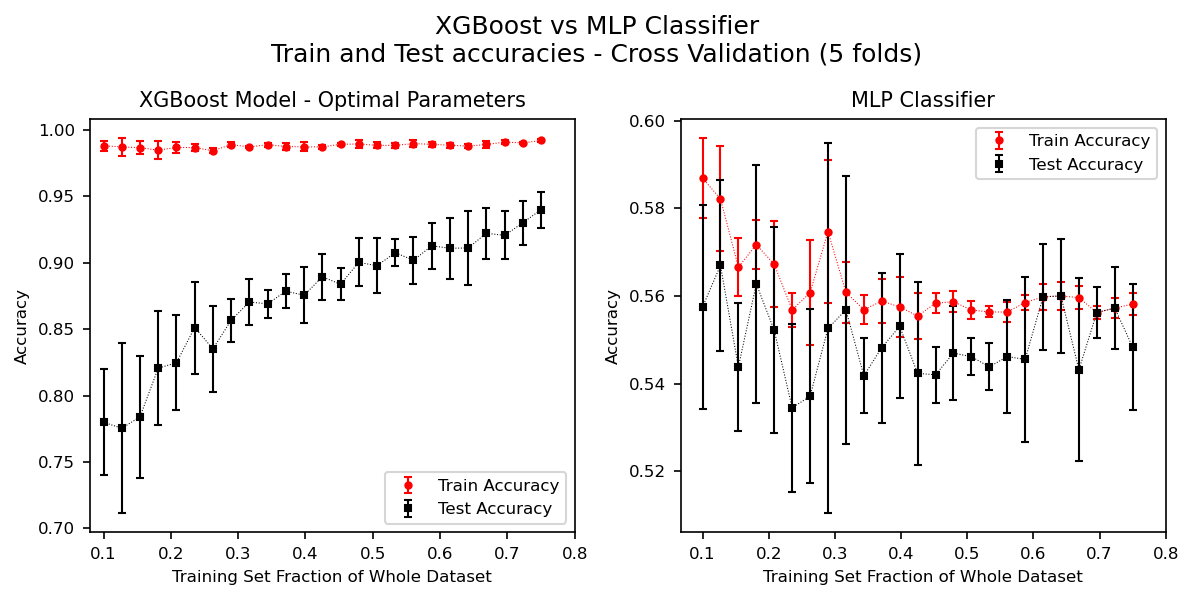

In [10]:
fig, axs = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
axs[0].plot(np.linspace(0.1, 0.75, 25), stats_XGB[:,0], color='red', linestyle='dotted', linewidth=0.5)
axs[0].errorbar(np.linspace(0.1, 0.75, 25), stats_XGB[:,0], yerr=stats_XGB[:,1], fmt='o', markersize=3, capsize=2, color='red', linewidth=1, label='Train Accuracy')
axs[0].plot(np.linspace(0.1, 0.75, 25), stats_XGB[:,2], color='black', linestyle='dotted', linewidth=0.5)
axs[0].errorbar(np.linspace(0.1, 0.75, 25), stats_XGB[:,2], yerr=stats_XGB[:,3], fmt='s', markersize=3, capsize=2, color='black', linewidth=1, label='Test Accuracy')
axs[0].set_xlabel('Training Set Fraction of Whole Dataset')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlim(0.08,0.76)
axs[0].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[0].set_title("XGBoost Model - Optimal Parameters")
axs[0].legend()


axs[1].plot(np.linspace(0.1, 0.75, 25), stats_NN[:,0], color='red', linestyle='dotted', linewidth=0.5)
axs[1].errorbar(np.linspace(0.1, 0.75, 25), stats_NN[:,0], yerr=stats_NN[:,1], fmt='o', markersize=3, capsize=2, color='red', linewidth=1, label='Train Accuracy')
axs[1].plot(np.linspace(0.1, 0.75, 25), stats_NN[:,2], color='black', linestyle='dotted', linewidth=0.5)
axs[1].errorbar(np.linspace(0.1, 0.75, 25), stats_NN[:,2], yerr=stats_NN[:,3], fmt='s', markersize=3, capsize=2, color='black', linewidth=1, label='Test Accuracy')
axs[1].set_xlabel('Training Set Fraction of Whole Dataset')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[1].set_title("MLP Classifier")
axs[1].legend()

fig.suptitle("XGBoost vs MLP Classifier\nTrain and Test accuracies - Cross Validation (5 folds)")

fig.tight_layout()